In [ ]:
"""Simulates Kuramoto model with given coupling matrix K."""

import numpy as np
import scipy as sp


def run_kuramoto(
    C: np.ndarray,
    distance_matrix: np.ndarray,
    dt: float,
    total_time: float,
    omega_range: tuple[float, float] = (0.0810, 0.2258),  # rad/s
    coupling_factor: float = 400.0,
    noise_factor: float = 0.0,
    mean_delay: float = 0.0,  # seconds; set to 0 to disable delays
    seed: int = 0,
    initial_phases: np.ndarray | None = None,
) -> np.ndarray:
    """Delayed Kuramoto integrator (Euler) with uniform intrinsic frequencies.

    C: (N,N) coupling matrix (2D). Diagonal is zeroed inside.
    distance_matrix: (N,N) distance matrix (2D) for computing per-edge delays.
    dt: timestep (seconds).
    total_time: total simulation time (seconds).
    omega_range: (low, high) uniform range for intrinsic frequencies (rad/s).
    coupling_factor: global coupling strength multiplier.
    noise_factor: scaling factor of white noise added to phase derivatives (rad/s).
    mean_delay: mean propagation delay (seconds). Set to 0 to disable delays.
    seed: RNG seed for reproducibility.
    initial_phases: initial phases of the oscillators (optional, radians).

    Returns phases with shape (N, n_steps), in radians.
    """
    C = np.array(C, dtype=float)
    np.fill_diagonal(C, 0.0)
    N = C.shape[0]

    # Normalize C row sums to avoid exploding coupling when using raw weights
    # row_sums = C.sum(axis=1, keepdims=True)
    # C = np.where(row_sums > 0, C / row_sums, 0.0)

    # normalize C to mean 1
    C = C / np.mean(C[C > 0])

    n_steps = int(total_time / dt)

    used_seed = seed if seed != 0 else np.random.SeedSequence().entropy
    rng = np.random.default_rng(used_seed)

    theta = (
        rng.uniform(0, 2 * np.pi, N)
        if initial_phases is None
        else np.asarray(initial_phases, dtype=float)
    )

    # Sample intrinsic frequencies uniformly in omega_range
    f = rng.normal(60, 5, N)  # Hz
    noise = rng.normal(0, 3, (N, n_steps)) # rad/s
    # mean_delay = 11e-3  # 11ms
    # delay_steps_base = mean_delay / dt  # convert to steps in t iteration

    omega = 2 * np.pi * f
    # omega = rng.uniform(omega_range[0], omega_range[1], size=N)

    # Noise array
    noise = (
        rng.normal(0, 3, (N, n_steps)) if noise_factor > 0 else np.zeros((N, n_steps))
    )

    # (Delays are disabled here; keep placeholder in case re-enabled)
    # if mean_delay > 0 and np.mean(distance_matrix) > 0:
    #     delay_steps_base = mean_delay / dt
    #     delay_steps = np.rint(
    #         delay_steps_base * distance_matrix / np.mean(distance_matrix)
    #     ).astype(int)
    # else:
    #     delay_steps = np.zeros_like(distance_matrix, dtype=int)



    phases = np.zeros((N, n_steps), dtype=float)
    phases[:, 0] = theta

    delays = np.rint(rng.normal(1e-3/dt, 0.2*1e-3/dt, size=n_steps)).astype(int)
    for t in range(1, n_steps):
        # Phase difference: theta_j - theta_i (correct sign for attractive coupling)
        # delay_steps = np.clip(delay_steps, 0, t - 1)
        # delayed_phases = np.take_along_axis(phases, delay_steps, axis=1)

        # Phase difference: source minus target
        # phase_diff = delayed_phases - phases[:, t - 1][:, None]  # (N, N)

        phase_diff = phases[:, np.clip(t-delays[t], 0, t - 1)][None, :] - phases[:, t - 1][:, None]

        dtheta = (
            omega
            + coupling_factor * np.sum(C * np.sin(phase_diff), axis=1)
            + noise_factor * noise[:, t]
        )

        phases[:, t] = (phases[:, t - 1] + dt * dtheta) % (2 * np.pi)

    return phases

In [ ]:
k_distance_array = np.load("output/averaged_patient_results.npz")["k_distance_average"]

In [ ]:
for k_idx in [0, 2, 4, 6, 8, 10]:

    corr_val = 0
    for rep in range(3):

        adj_mat = 1 / k_distance_array[:, :, k_idx]  # Direct indexing, no adjustment needed
        adj_mat[np.isnan(adj_mat)] = 0

        # normalise adj_mat such that rows sum to 1
        # row_sums = adj_mat.sum(axis=1, keepdims=True)
        # adj_mat = adj_mat / row_sums
        # adj_mat[np.isnan(adj_mat)] = 0

        dist_mat = k_distance_array[:, :, k_idx]
        dist_mat[np.isnan(dist_mat)] = 0  # with kdist isnan

        phases = run_kuramoto(
            C=patient_sc,  # adj_mat,
            distance_matrix=dist_mat,
            dt=0.0001,
            total_time=3,
            coupling_factor=18,
            noise_factor=1,
            mean_delay=0,  # disabled
            seed=0,
        )

        simulated_ts = np.sin(phases[:, 5000:])  # ignore initial transient
        simulated_fc = np.corrcoef(simulated_ts)

        sim_triu = simulated_fc[np.triu_indices(simulated_fc.shape[0], k=1)]
        patient_triu = patient_fc[np.triu_indices(patient_fc.shape[0], k=1)]

        pearson = sp.stats.pearsonr(sim_triu, patient_triu)[0]
        print(k_idx, pearson)

        corr_val += pearson

    print(f"k={k_idx}, avg corr={corr_val / 3:.4f}")



/tmp/ipykernel_26294/2427164684.py:6: RuntimeWarning: divide by zero encountered in divide
  adj_mat = 1 / k_distance_array[:, :, k_idx]  # Direct indexing, no adjustment needed


0 0.0832417799370066
0 0.10846170028440781
0 0.03923184611246018
k=0, avg corr=0.0770
2 0.10383161065124842
2 0.0521375080737628
2 0.04157984116036372
k=2, avg corr=0.0658
4 0.06266430671853872
4 0.02684285721351763
4 0.08200315552471044
k=4, avg corr=0.0572
6 0.057250312730008864
6 0.04076524527789968
6 0.0952884304194141
k=6, avg corr=0.0644
8 0.07201819027055287
8 0.046336083654441605
8 0.055712432575019635
k=8, avg corr=0.0580
10 0.08454461675863692
10 0.0704903719184478
10 0.08352050227986337
k=10, avg corr=0.0795


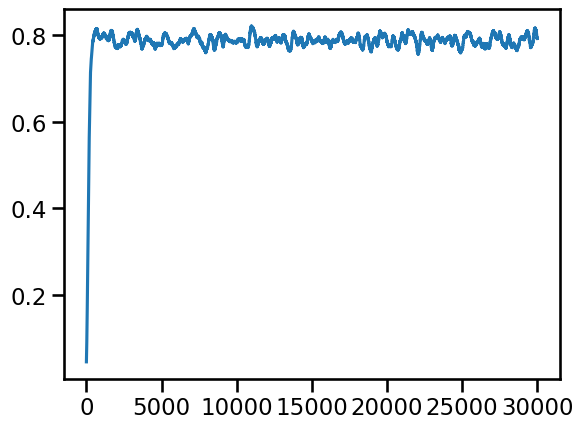

In [ ]:
# plot order parameter
order = np.abs(np.sum(np.exp(1j * phases), axis=0)) / phases.shape[0]
plt.plot(order)

In [ ]:
        adj_mat = 1 / k_distance_array[:, :, 3]  # Direct indexing, no adjustment needed
        adj_mat[np.isnan(adj_mat)] = 0

        # normalise adj_mat such that rows sum to 1
        # row_sums = adj_mat.sum(axis=1, keepdims=True)
        # adj_mat = adj_mat / row_sums
        # adj_mat[np.isnan(adj_mat)] = 0

        dist_mat = k_distance_array[:, :, k_idx]
        dist_mat[np.isnan(dist_mat)] = 0  # with kdist isnan

        phases = run_kuramoto(
            C=patient_sc,  # adj_mat,
            distance_matrix=dist_mat,
            dt=0.0001,
            total_time=3,
            coupling_factor=18,
            noise_factor=1,
            mean_delay=0,  # disabled
            seed=0,
        )

/tmp/ipykernel_26294/264127976.py:1: RuntimeWarning: divide by zero encountered in divide
  adj_mat = 1 / k_distance_array[:, :, 3]  # Direct indexing, no adjustment needed


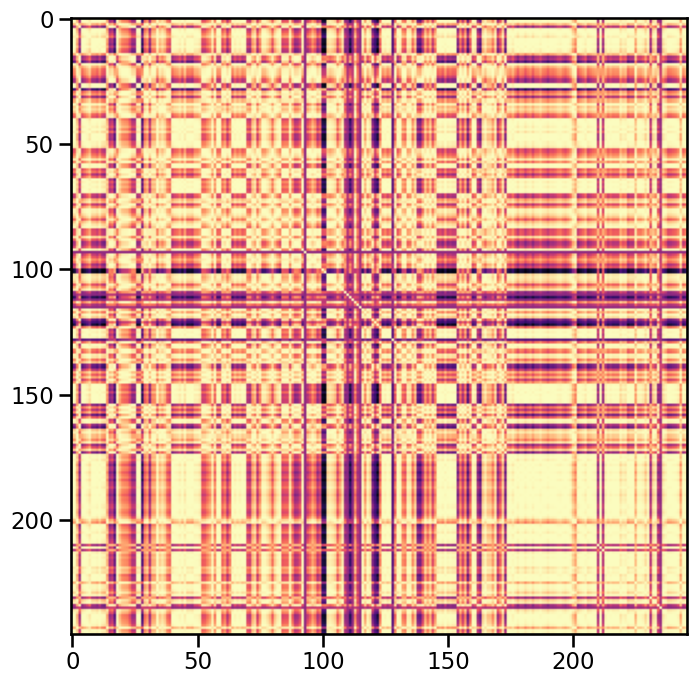

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(simulated_fc, cmap="magma")

In [ ]:
simulated_ts = np.sin(phases[:, 5000:])  # ignore initial transient
simulated_fc = np.corrcoef(simulated_ts)

sim_triu = simulated_fc[np.triu_indices(simulated_fc.shape[0], k=1)]
patient_triu = patient_fc[np.triu_indices(patient_fc.shape[0], k=1)]

print(sp.stats.pearsonr(sim_triu, patient_triu))

PearsonRResult(statistic=np.float64(0.09003636657437308), pvalue=np.float64(2.7959484764405647e-55))


/tmp/ipykernel_26294/2986009659.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


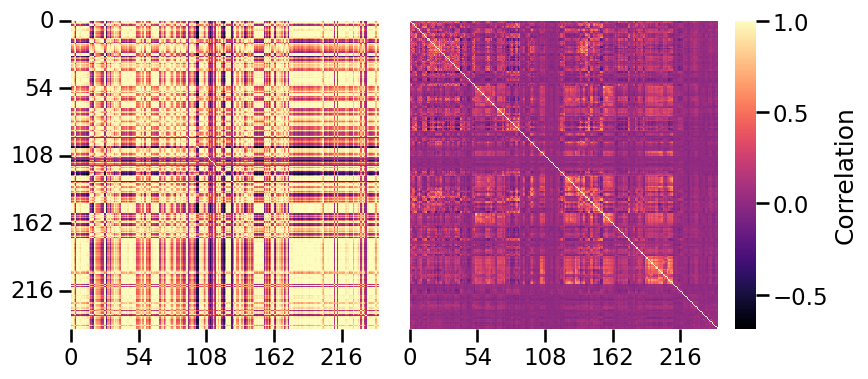

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_context("talk")
vmin = min(np.nanmin(simulated_fc), np.nanmin(patient_fc))
vmax = max(np.nanmax(simulated_fc), np.nanmax(patient_fc))

fig = plt.figure(figsize=(9, 4))
# smaller spacer to bring panels closer, slightly wider colorbar
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.06], wspace=0.02)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
cax = fig.add_subplot(gs[0, 2])

sns.heatmap(
    simulated_fc, ax=ax0, vmin=vmin, vmax=vmax, cmap="magma", cbar=False, square=True
)

sns.heatmap(
    patient_fc,
    ax=ax1,
    vmin=vmin,
    vmax=vmax,
    cmap="magma",
    cbar=True,
    cbar_ax=cax,
    square=True,
)

# explicitly set x and y ticks
tick_positions = [0, 54, 108, 162, 216]
tick_labels = ["0", "54", "108", "162", "216"]

for ax in (ax0, ax1):
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=90)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(tick_labels)

# hide y-axis labels on the second matrix
# ax1.set_yticklabels([])
ax1.tick_params(axis="y", left=False, labelleft=False)

cax.set_ylabel("Correlation")

ax0.tick_params(axis="x", labelrotation=0)
ax1.tick_params(axis="x", labelrotation=0)
plt.tight_layout()
plt.show()